In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Light Curves with Different Pipelines

Sadly, we expect *most* of the weirdest behavior to be artifacts either from systematic effects, or from data processing.

The bulk produced light curves we used to find all the anomalies were produced with an `eleanor` pipeline. Every pipeline is optimized for discovering different phenomena and can affect light curve production differently, so our first step is to recreate the interesting light curve, and see if we can eliminate as many systematic explanations as possible, or else discover the issue.

## Lightkurve

In [2]:
import lightkurve
import eleanor
from lightkurve.correctors import DesignMatrix, RegressionCorrector, PLDCorrector


In [3]:
tic = 270577175
sector = 6
i=0
while i<10:
    try:
        print('trying')
        tpf = lightkurve.search_tesscut(f'TIC {tic}',sector=sector).download_all(cutout_size=(15,15))
        print('success')
        tpf=tpf[0]
        break
    except Exception as e:
        print(f'error: {e}')
        i+=1


trying
success


Many of the sources may have bad defaults or no predefined mask, you'll probably have to create a custom aperture mask. See `lightkurve` Section 3 [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-custom-aperture-photometry.html) for guidance.

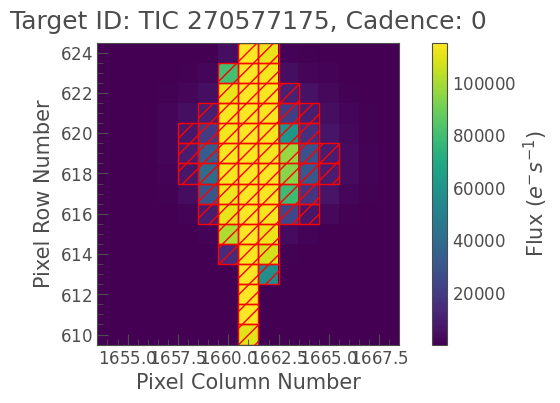

In [4]:
custom_mask = tpf[0].create_threshold_mask(threshold=15)
tpf.plot(aperture_mask=custom_mask)

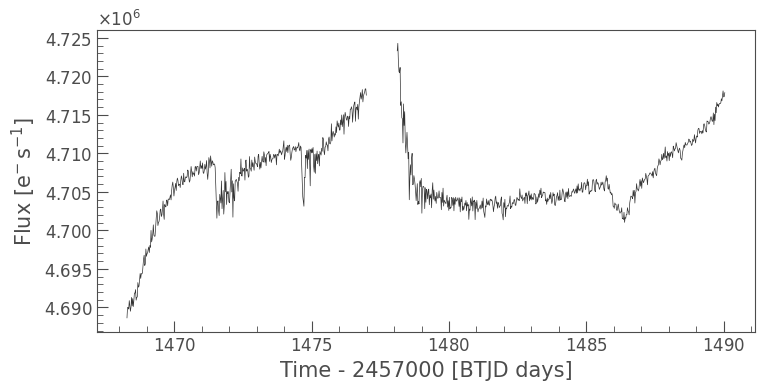

In [5]:
lc = tpf.to_lightcurve(aperture_mask=custom_mask)
lc.plot();

This is raw flux without any correction, let's try different background subtractions to see if our mystery signal resolves itself.

### Simple Background Subtraction

In [6]:
regressors = tpf.flux[:, ~custom_mask]
regressors.shape

(981, 164)

In [7]:
bkg = np.median(regressors, axis=1)
bkg -= np.percentile(bkg, 5)

npix = custom_mask.sum()
median_subtracted_lc = lc - npix * bkg

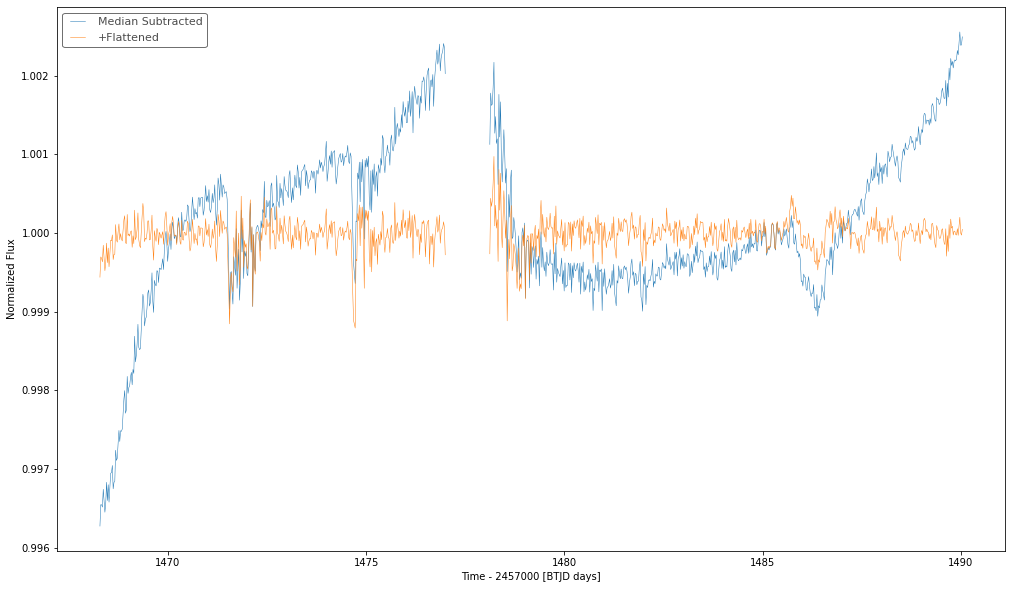

In [8]:
fig, ax = plt.subplots(1, figsize=(17,10))
#lc.plot(ax=ax)
median_subtracted_lc.plot(ax=ax, normalize=True, label="Median Subtracted")
median_subtracted_lc.flatten().plot(ax=ax, normalize=True, label="+Flattened")

#ax.plot(lc.time.value, bkg)


### [Linear Regression](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html)

It may be necessary to remove scattered light. Scattered light is recognizable in TESS FFI light curves as a brightening trend in both halves of each light curve. The median background subtraction used above may account for this well enough, but if not try a linear regression or the pixel level decorrelation (PLD) corrector. If this removes the signal of interest, examine the pixel level information and discard the corrections if your signal is in fact localized (not present everywhere).

In [16]:
# Make an aperture mask and an uncorrected light curve
uncorrected_lc = tpf.to_lightcurve(aperture_mask=custom_mask)

# Make a design matrix and pass it to a linear regression corrector
dm = DesignMatrix(tpf.flux[:, ~custom_mask], name='regressors').pca(5).append_constant()
#uncorrected_lc = uncorrected_lc.remove_nans()
rc = RegressionCorrector(uncorrected_lc)
corrected_ffi_lc = rc.correct(dm)

# Optional: Remove the scattered light, allowing for the large offset from scattered light
corrected_ffi_lc = uncorrected_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)
corrected_ffi_lc.plot()

ValueError: Input light curve has NaNs in time or flux. Please remove NaNs before correction (e.g. using `lc = lc.remove_nans()`).

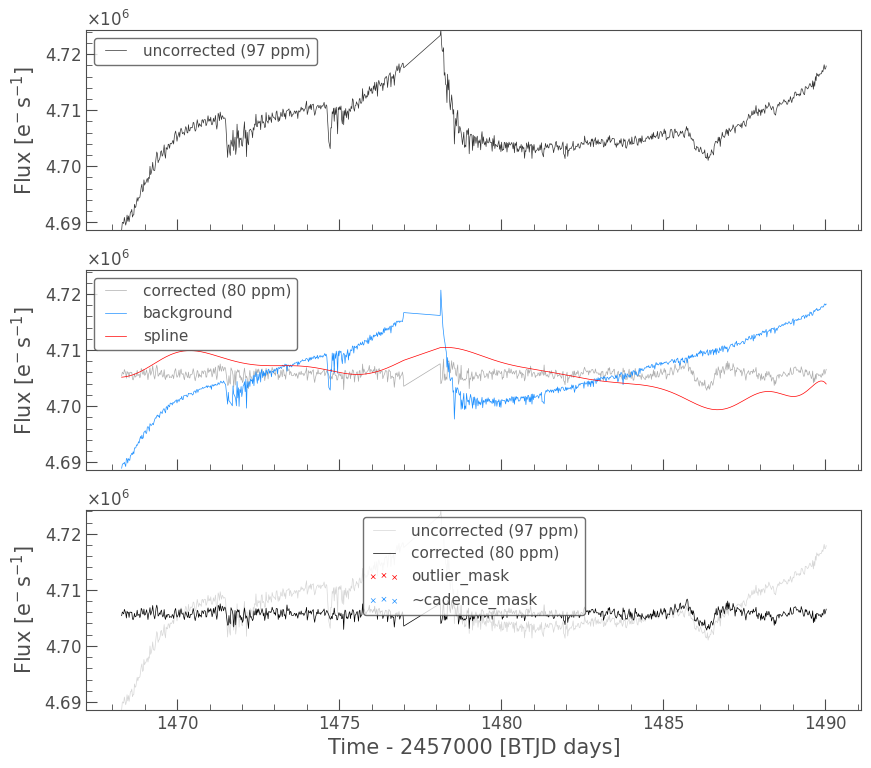

In [13]:
pld = PLDCorrector(tpf, aperture_mask=custom_mask)
pld_corrected_lc = pld.correct(restore_trend=False, pca_components=5)
pld.diagnose();

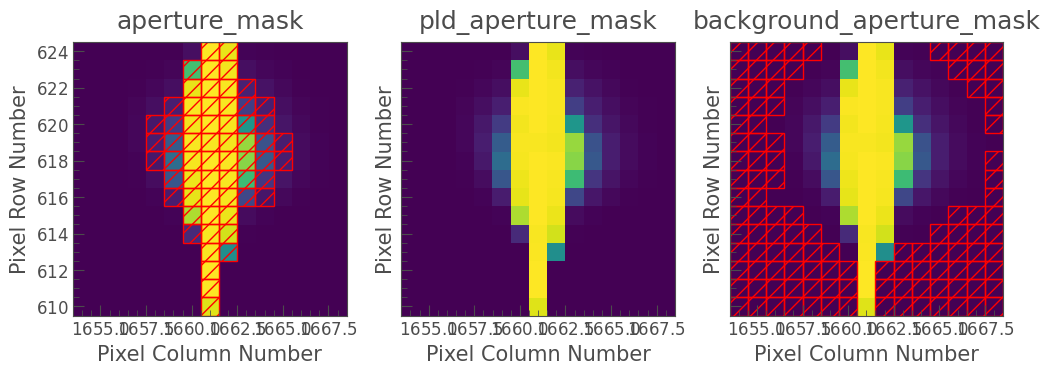

In [14]:
pld.diagnose_masks();

## eleanor

In [36]:
star = eleanor.Source(tic=270577175, sector=6)
star

/home/astro/phrdhx/.local/lib/python3.7/site-packages/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]


In [35]:
eleanor_data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_pca=True)

/home/astro/phrdhx/micromamba/envs/auto_exo/lib/python3.7/site-packages/lightkurve/lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
/home/astro/phrdhx/micromamba/envs/auto_exo/lib/python3.7/site-packages/lightkurve/lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
/home/astro/phrdhx/micromamba/envs/auto_exo/lib/python3.7/site-packages/lightkurve/lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
/home/astro/phrdhx/micromamba/envs/auto_exo/lib/python3.7/site-packages/lightkurve/lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,


Check that the aperture makes sense

In [31]:
vis = eleanor.Visualize(data)
fig = vis.aperture_contour()

NameError: name 'data' is not defined

Look at the eleanor light curves, see if they match ours

In [ ]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, label="raw")
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, label="corr")
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), label="PCA")
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, label="PSF")
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend()

Let's check if the background is strongly related to the behaviors we're seeing

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data.time[q], data.flux_bkg[q], 'k', label='1D postcard', linewidth=3)
plt.plot(data.time[q], data.tpf_flux_bkg[q], 'r--', label='1D TPF', linewidth=2)
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

## TESS mission and other public light curve sources

Use lightkurve to check what other ready-made light curves exist and plot them.

In [ ]:
i=0
while i<10:
    try:
        print('trying')
        lcfsearch = lightkurve.search_lightcurve(f'TIC {tic}',sector=sector)
        if (len(lcfsearch) > 0):
            exptimes = lcfsearch.exptime.value
            exptimes = [str(int(t)) for t in exptimes/60]
            lcf = lcfsearch.download_all()
            for i in np.arange(len(lcf)):
                plt.figure(figsize=(15,5))
                plt.plot(lcf[i].time.value,lcf[i].flux.value)
                plt.title(lcf[i].author + ' ' + exptimes[i]+'min cadence',fontsize=16)
                plt.ylabel('Normalized Flux',fontsize=16)
                plt.xlabel('Time [BJD - 2457000]',fontsize=16)
        break
    except Exception:
        print(f'error: {Exception}')
        i+=1

# It's still weird!

### Check for contamination

In [ ]:
tpf.plot_pixels(corrector_func=lambda x: x.remove_nans().flatten().remove_outliers(), show_flux=True, aperture_mask=custom_mask);


If the behavior is still present, check to see if there's anything funky in the background of the TPF, like a rolling signal, or some transient that coincides with the target that could mess up a simple background subtraction

Let's watch a video of the pixels and see if anything pops out immediately (like some really bad background, a saturated source dominating the flux, cosmic rays or other nonsense).

In [ ]:
tpf.animate()

# Is it periodic? Phase fold that

Choose which light curve you'd like to work with from the workflows above, and define it as `working_lc`

In [ ]:
working_lc = median_subtracted_lc.flatten()

In [ ]:
pg = working_lc.normalize(unit='ppm').to_periodogram()
pg.plot(scale='linear');

In [ ]:

period = pg.period_at_max_power
period

In [ ]:
from ipywidgets import FloatSlider, interact

In [ ]:
def fold_lc(period):
    working_lc.fold(period).scatter(label=f'Period = {period:.3f} d');
    return
interact(fold_lc, period=FloatSlider(min=0.01, max=15.0, value=period.value, step=.001))

In [ ]:
from PhaseFold import phasefold

In [ ]:
phasefold.fold(working_lc, sect=sector)